In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman

df_imagenet = pd.read_csv('../../calibration-study/ImageNet_tss.csv')
df_cifar10 = pd.read_csv('../../calibration-study/cifar10_tss.csv')
df_cifar100 = pd.read_csv('../../calibration-study/cifar100_tss.csv')

metrics_to_extract = [
    'pre_ECE_15', 'pre_ECE_em_15', 'pre_cwCE_15', 'pre_KSCE', 'pre_KDECE', 'pre_MMCE','pre_cwCE_em_15'
]

df_imagenet = df_imagenet[['config', 'acc', 'arch'] +metrics_to_extract]
df_cifar10 = df_cifar10[['config', 'acc', 'arch'] +metrics_to_extract]
df_cifar100 = df_cifar100[['config', 'acc', 'arch'] +metrics_to_extract]
# 
metrics_to_rename = [
    'ECE', 'ECE_em', 'cwCE', 'KSCE', 'KDECE', 'MMCE', 'cwCE_em'
]
df_imagenet.columns = ['config', 'acc', 'arch'] +metrics_to_rename
df_cifar10.columns = ['config', 'acc', 'arch'] +metrics_to_rename
df_cifar100.columns = ['config', 'acc', 'arch'] +metrics_to_rename
for metric in metrics_to_rename:
    for dataset, df in [('IN', df_imagenet), ('C10', df_cifar10), ('C100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].copy()


merged_df = df_imagenet[['config'] + [f"{metric}_IN" for metric in metrics_to_rename]].merge(
    df_cifar10[['config'] + [f"{metric}_C10" for metric in metrics_to_rename]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_C100" for metric in metrics_to_rename]], on='config', how='outer'
)


/tmp/ipykernel_2371305/1549208597.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[metric].copy()


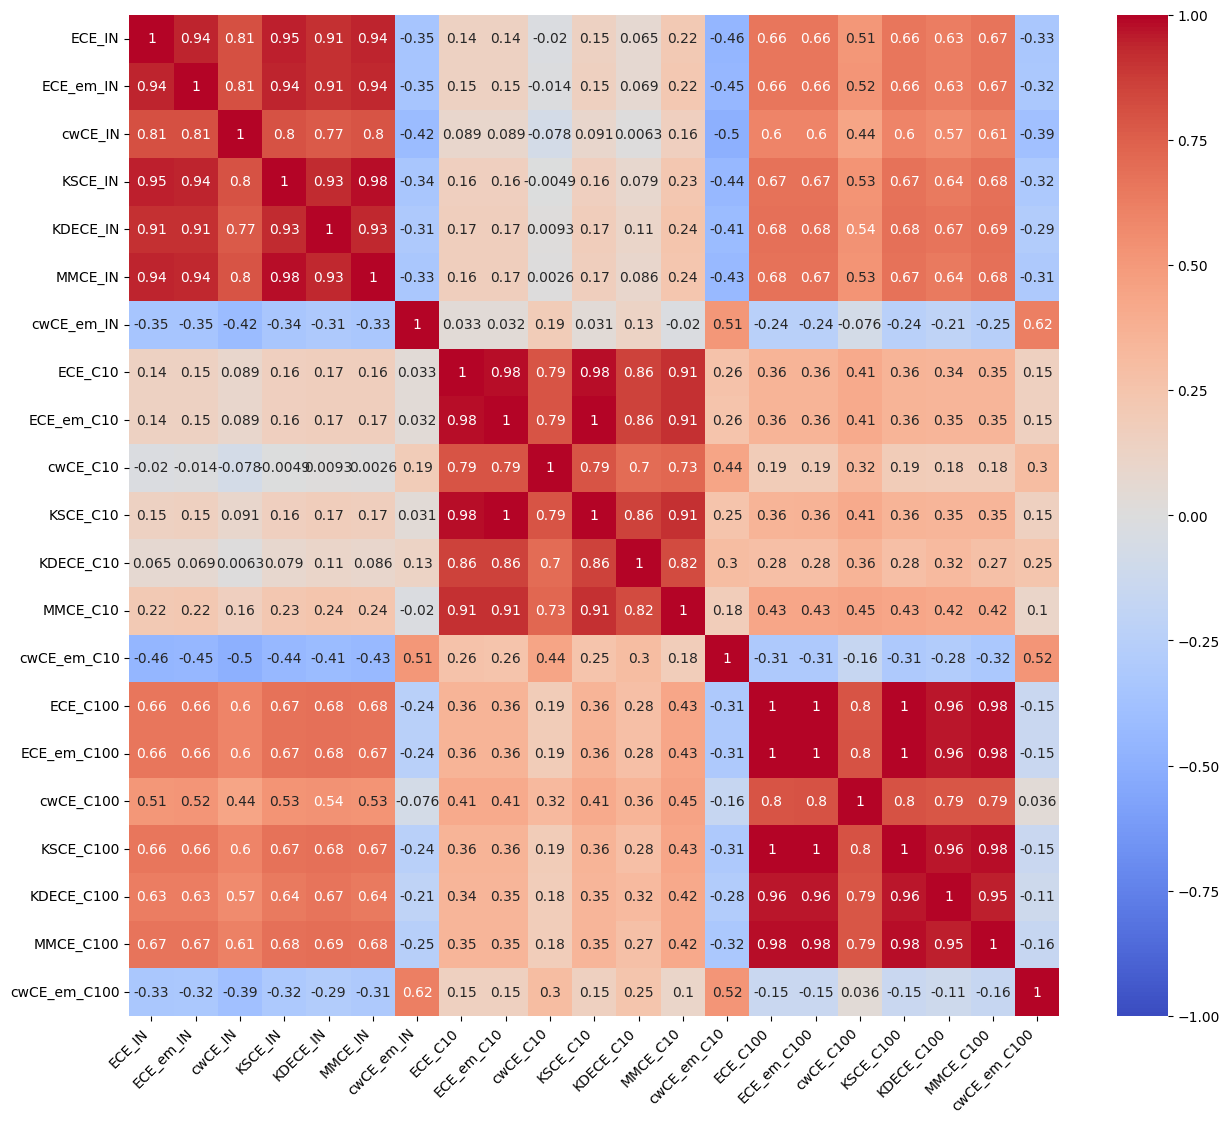

In [46]:


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_rename:
    for dataset in ['IN', 'C10', 'C100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['IN', 'C10', 'C100'] for metric in metrics_to_rename]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Rotate the bottom labels
plt.xticks(rotation=45, ha='right')

# plt.savefig("fig/Kendall_Metric.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()
